In [3]:
!pip install pyvis

   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/756.0 kB ? eta -:--:--
   ------------- -------------------------- 262.1/756.0 kB ? eta -:--:--
   ------------- -------------------------- 262.1/756.0 kB ? eta -:--:--
   -------------------------- ----------- 524.3/756.0 kB 670.4 kB/s eta 0:00:01
   -------------------------- ----------- 524.3/756.0 kB 670.4 kB/s eta 0:00:01
   -------------------------- ----------- 524.3/756.0 kB 670.4 kB/s eta 0:00:01
   -------------------------------------- 756.0/756.0 kB 458.2 kB/s eta 0:00:00


DEPRECATION: Loading egg at c:\users\asus\anaconda3\lib\site-packages\matlabengine-24.2-py3.11.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import pandas as pd

# Load your Excel file
df = pd.read_excel("Company Tier Data.xlsx")

# Preview the data
df.head()

,Product,Company,Tier,Component,is a part of,is a part of.1
0,drone battery uav,SUJATA COMPUTERS PVT LTD (MII),Tier1,Drone,-,-
1,fully assembled drone uav,ideaforge technology ltd,Tier1,Drone,-,-
2,Surveillance type unmanned aerial vehicle (Dro...,pratham enterprises pvt ltd,Tier1,Drone,-,-
3,Surveillance type unmanned aerial vehicle (Dro...,aavya enterprises pvt ltd,Tier1,Drone,-,-
4,Hexa Drone 2K,r j enterprises pvt ltd,Tier1,Drone,-,-


Graph saved as drone_supply_chain.png


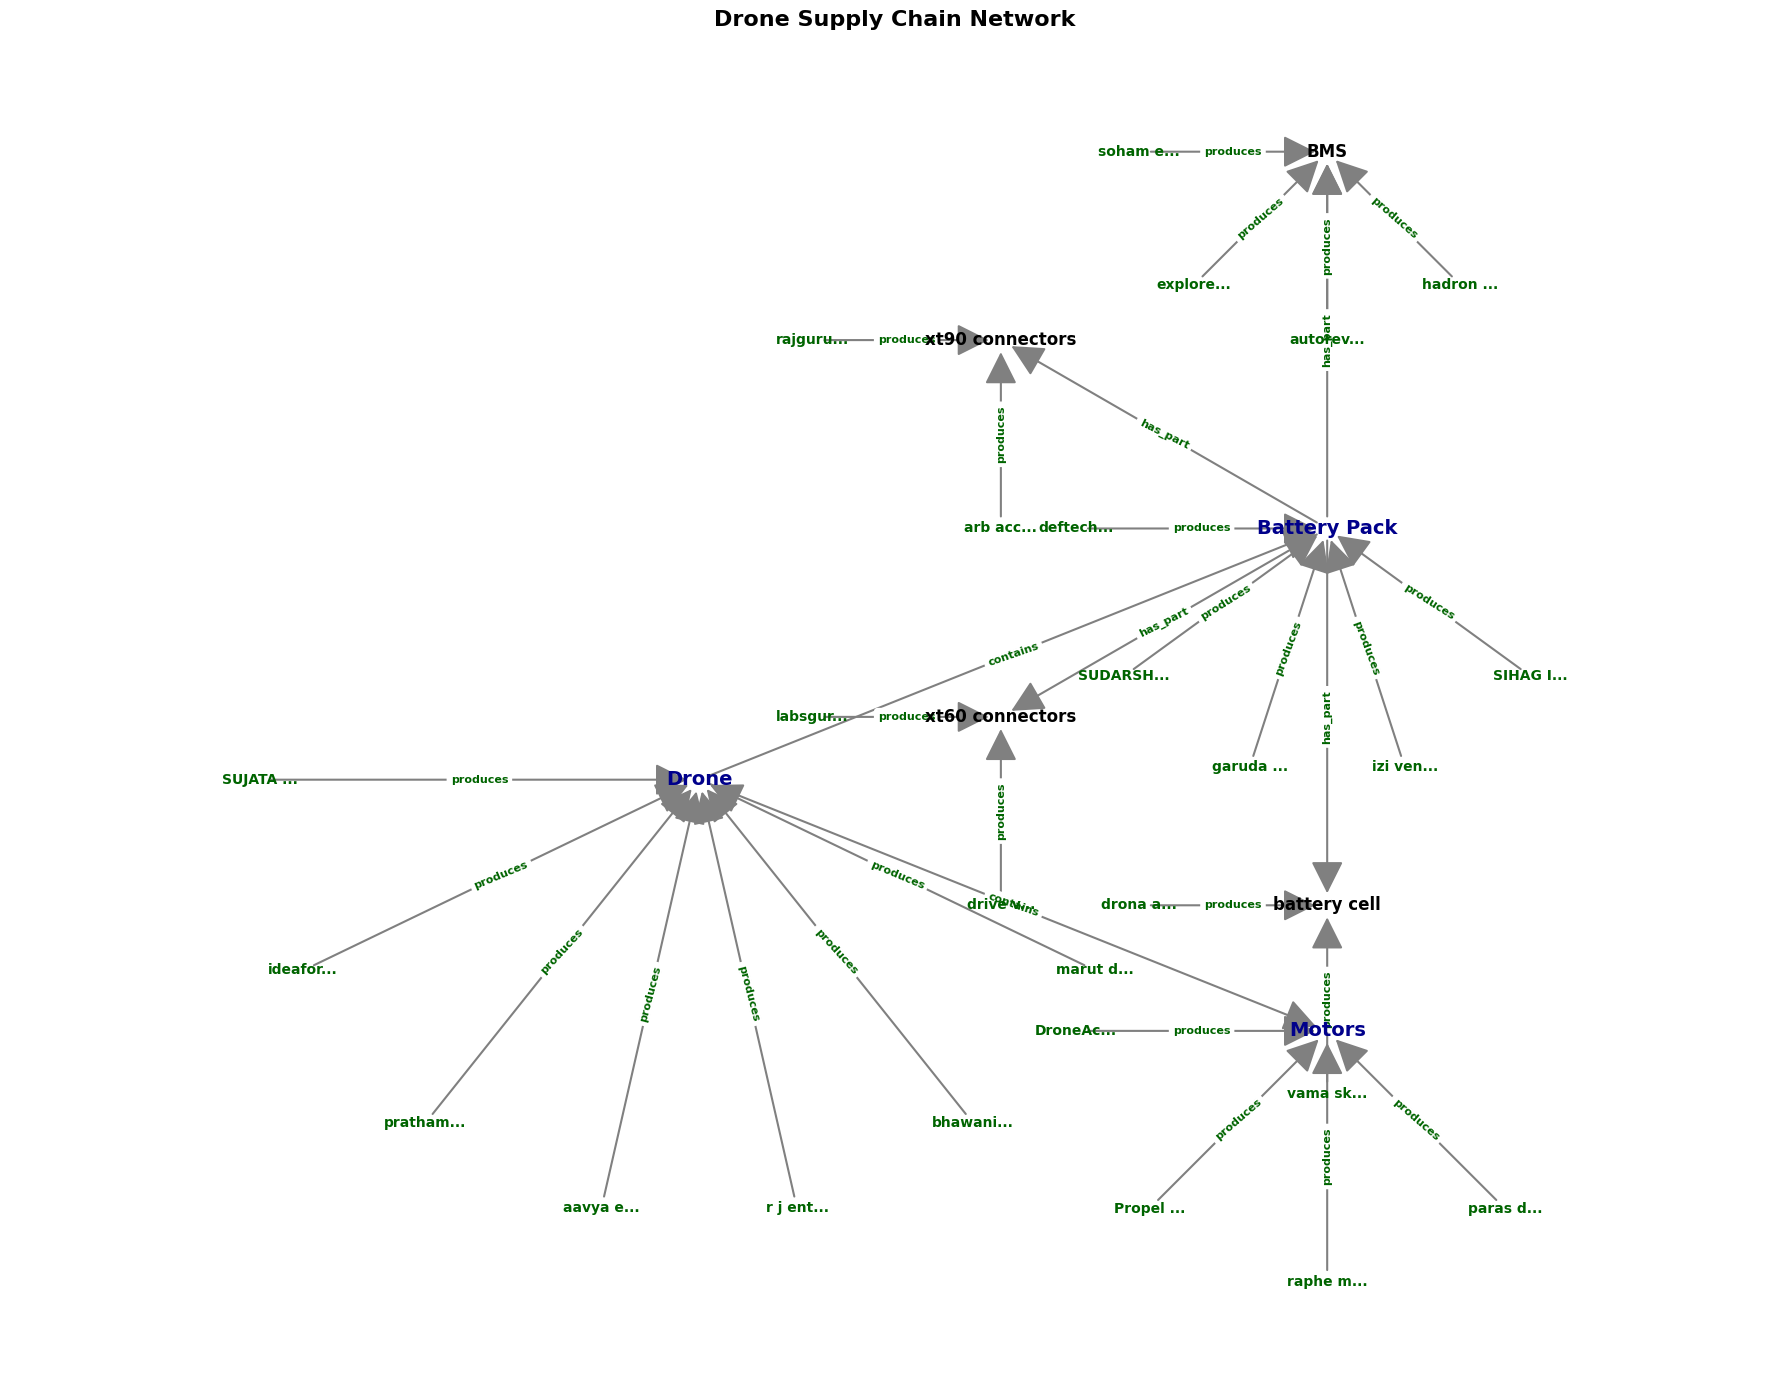

In [73]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math

# Load the Excel file
df = pd.read_excel("Company Tier Data.xlsx")

# Create the directed graph
G = nx.DiGraph()

# === Step 1: Drone companies ===
drone_companies = df[(df['Component'] == 'Drone') & (df['Company'] != '-')]['Company'].unique()
for company in drone_companies:
    G.add_edge(company, 'Drone', label='produces')

# === Step 2: Main components of Drone ===
G.add_edge('Drone', 'Battery Pack', label='contains')
G.add_edge('Drone', 'Motors', label='contains')

# === Step 3: Battery Pack companies ===
battery_companies = df[(df['Component'] == 'Battery Pack') & (df['Company'] != '-')]['Company'].unique()
for company in battery_companies:
    G.add_edge(company, 'Battery Pack', label='produces')

# === Step 4: Motors companies ===
motor_companies = df[(df['Component'] == 'Motors') & (df['Company'] != '-')]['Company'].unique()
for company in motor_companies:
    G.add_edge(company, 'Motors', label='produces')

# === Step 5: Subcomponents of Battery Pack ===
battery_subs = df[df['is a part of'] == 'Battery Pack']['Component'].unique()
for comp in battery_subs:
    G.add_edge('Battery Pack', comp, label='has_part')

# === Step 6: Companies for subcomponents ===
for comp in battery_subs:
    comp_companies = df[(df['Component'] == comp) & (df['Company'] != '-')]['Company'].unique()
    for company in comp_companies:
        G.add_edge(company, comp, label='produces')

# === Layout setup ===
pos = {}

# Drone at center
pos['Drone'] = (0, 0)

# Drone companies in semicircle
n1 = len(drone_companies)
r1 = 7
for i, company in enumerate(drone_companies):
    angle = math.pi + (math.pi * i / n1)
    pos[company] = (r1 * math.cos(angle), r1 * math.sin(angle))

# Battery Pack and Motors
pos['Battery Pack'] = (10, 4)
pos['Motors'] = (10, -4)

# Battery companies
n2 = len(battery_companies)
r2 = 4
for i, company in enumerate(battery_companies):
    angle = math.pi + (math.pi * i / n2)
    cx, cy = pos['Battery Pack']
    pos[company] = (cx + r2 * math.cos(angle), cy + r2 * math.sin(angle))

# Motors companies
n3 = len(motor_companies)
r3 = 4
for i, company in enumerate(motor_companies):
    angle = math.pi + (math.pi * i / n3)
    cx, cy = pos['Motors']
    pos[company] = (cx + r3 * math.cos(angle), cy + r3 * math.sin(angle))

# Spread subcomponents of Battery Pack in a wider arc
n4 = len(battery_subcomponents)
r4 = 6  # increase radius to spread out further
for i, comp in enumerate(battery_subcomponents):
    angle = math.pi / 2 + (math.pi * i / (n4 - 1))  # spread from 90° to 270°
    cx, cy = pos['Battery Pack']
    pos[comp] = (cx + r4 * math.cos(angle), cy + r4 * math.sin(angle))


# Subcomponent companies
for comp in battery_subs:
    comp_companies = df[(df['Component'] == comp) & (df['Company'] != '-')]['Company'].unique()
    n = len(comp_companies)
    r = 3
    for i, company in enumerate(comp_companies):
        angle = math.pi + (math.pi * i / n)
        cx, cy = pos[comp]
        pos[company] = (cx + r * math.cos(angle), cy + r * math.sin(angle))

# === Color and size nodes ===
node_colors = []
node_sizes = []
all_company_nodes = set(drone_companies) | set(battery_companies) | set(motor_companies)
for comp in battery_subs:
    all_company_nodes |= set(df[df['Component'] == comp]['Company'].values)

for node in G.nodes:
    if node in all_company_nodes:
        node_colors.append('lightgreen')
        node_sizes.append(2000)
    elif node in ['Drone', 'Battery Pack', 'Motors']:
        node_colors.append('skyblue')
        node_sizes.append(3500)
    else:
        node_colors.append('lightgray')
        node_sizes.append(2500)

# === Draw Graph ===
plt.figure(figsize=(18, 14))
nx.draw_networkx_edges(G, pos, arrows=True, edge_color='gray', arrowsize=50, width=1.5)

# Edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                             font_color='darkgreen', font_size=8, font_weight='bold')

# Text labels
for node, (x, y) in pos.items():
    if node in all_company_nodes:
        display_name = node if len(node) <= 7 else node[:7] + "..."
        plt.text(x, y, display_name, fontsize=10, ha='center', va='center',
                 weight='bold', color='darkgreen')
    elif node in ['Drone', 'Battery Pack', 'Motors']:
        plt.text(x, y, node, fontsize=14, ha='center', va='center',
                 weight='bold', color='darkblue')
    else:
        plt.text(x, y, node, fontsize=12, ha='center', va='center',
                 weight='bold', color='black')

# Final touches
plt.title('Drone Supply Chain Network', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.axis('off')

# Save the figure instead of showing
plt.savefig("drone_supply_chain.png", dpi=300, bbox_inches='tight')
print("Graph saved as drone_supply_chain.png")
plt.show()
